<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Gradient Descent: Iteratively Minimizing Loss Functions 

_Authors: Kiefer Katovich (SF)_

---

### Learning Objectives
- Review derivatives and partial derivatives
- Review the least squared loss function for regression
- Understand how gradient descent minimizes the loss function
- Manually code the gradient descent algorithm from scratch for simple linear regression
- Learn how the gradient descent code changes for multiple linear regression
- Visualize gradient descent optimizing the coefficients of a regression
- Understand the pitfalls of gradient descent and observe when it can fail
- Understand how stochastic gradient descent is different, and what the benefits are


### Lesson Guide
- [Introduction to gradient descent](#intro)
- [Review of derivatives](#derivatives)
- [Review of the least squares loss function for regression](#lsq-loss)
    - [Exercise 1: code the loss function](#exercise-1)
- [Partial derivatives of the loss function](#partial-derivatives)
    - [Partial derivative with respect to $\beta_0$](#beta0)
    - [Partial derivative with respect to $\beta_1$](#beta1)
    - [Exercise 2: code the partial derivative functions](#exercise-2)
    - [Iterating towards the minimum](#iterating)
- [Coding the gradient descent algorithm for SLR](#code-descent)
    - [Exercise 3: code the beta coefficient update](#exercise-3)
    - [Exercise 4: code the gradient descent iterator](#exercise-4)
- [Exercise 5: test the gradient descent algorithm on the simple housing data](#exercise-5)
- [Linear algebra MLR generalization of gradient descent](#linalg)
- [Interactive visualization of gradient descent](#interactive)
- [Gradient descent can fail: a toy example](#fail)
- [Stochastic gradient descent](#stochastic)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='intro'></a>

## Introduction to gradient descent

---

Gradient descent is an algorithm used to minimize functions such as the least-squares loss in regression. It is a very popular in machine learning and statistics.

The gradient descent algorithim uses the derivative of the loss function to move in the direction where the loss function is "descending".

<a id='derivatives'></a>
## Derivatives
---

The derivative of a function quantifies the **rate of change** of the the function with respect to another quantity. 

Imagine the derivative as a tangent line on the edge of another function. For example, in the image below, if the black curve was the velocity of a car, the red tangent would represent the derivative of velocity at that point: the acceleration of the car.

![derivative](https://camo.githubusercontent.com/2f70b084174b825e3ad88564301f9aaf46997fd3/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30662f54616e67656e745f746f5f615f63757276652e737667)



The value of the derivative of a function indicates whether the function is **increasing or decreasing** at that point/input value. 

* If the function is not changing (the tangent line is flat), **the derivative is 0**.
* If the function is increasing (the tangent slope is positive), **the derivative is positive**.
* If the function is decreasing (the tangent slope is negative), **the derivative is negative**.

**In the case of convex loss functions like the least squared loss, the point where the derivative is 0 is the minimum.**

<a id='lsq-loss'></a>

## Review: the least squares loss function for regression

---

Recall the least squares loss function:

### $$\frac{1}{N}\sum_{i=1}^N{\left(y_i - \hat{y}_i\right)^2}$$

As well as the formula for a linear regression with a single predictor variable:

### $$y = \beta_0 + \beta_1x_1$$

We can redefine the loss function, inserting the regression formula:

### $$\frac{1}{N}\sum_{i=1}^N{\left(y_i - (\beta_0 + \beta_1x_i)\right)^2}$$

<a id='exercise-1'></a>
### Exercise 1: code the loss function

Write a python function for the least squares loss of this simple linear regression in terms of:
- `y`: vector of y values
- `beta_0`: intercept coefficient
- `beta_1`: coefficient for predictor `x`
- `x`: vector of predictor values

In [2]:
def mean_squared_error(x, y_true, beta0, beta1):
    y_pred = beta0 + x * beta1
    mean_sq_err = np.mean((y_true - y_pred)**2)
    return mean_sq_err

<a id='partial-derivatives'></a>
## Partial derivatives of the loss function

---

We are going to calculate the two partial derivatives of the loss function. Partial derivatives are derivatives with respect to one variable while holding the other variables constant. Our partial derivatives will be:

* The derivative of the loss function with respect to beta0 (the intercept)
* The derivative of the loss function with respect to beta1 (the slope/coefficient for x1)

This is because the loss function is defined by these two parameters. In other words, the value of the loss function depends on the changes in beta0 and beta1. 

What about x and y? Those variables affect the calculation of the loss, but we are not able to change them to adjust the error. We can only adjust the parameters of our model.

<a id='beta0'></a>
### The partial derivative with respect to $\beta_0$:

### $$\frac{\delta}{\delta\beta_0} = \frac{2}{N}\sum_{i=1}^N{-\left(y_i - (\beta_0 + \beta_1x_1)\right)}$$

<a id='beta1'></a>
### The partial derivative with respect to $\beta_1$:

### $$\frac{\delta}{\delta\beta_1} = \frac{2}{N}\sum_{i=1}^N{-x_i\left(y_i - (\beta_0 + \beta_1x_1)\right)}$$


<a id='exercise-2'></a>
### Exercise 2: code the partial derivative functions

The functions should return the gradients (partial derivatives) of `beta0` and `beta1`.

In [3]:
def partial_beta0(x, y, beta0, beta1):
    N = len(y)
    beta0_gradient = 0.
    for i in range(len(y)):
        beta0_gradient += (2./N * -1 * (y[i] - (beta0 + beta1*x[i])))
    return beta0_gradient

def partial_beta1(x, y, beta0, beta1):
    N = len(y)
    beta1_gradient = 0.
    for i in range(len(y)):
        beta1_gradient += (2./N * -1 * x[i] * (y[i] - (beta0 + beta1*x[i])))
    return beta1_gradient


---

<a id='iterating'></a>
### Iterating towards the minimum

So what are we going to do with these partial derivatives?

Recall that a positive derivative indicates an increasing function and a negative derivative indicates a decreasing function. 

If we were to subtract a tiny fraction of the partial derivative of $\beta_1$ from $\beta_1$, and subtract a tiny fraction of the partial derivative of $\beta_0$ from $\beta_0$, we will adjust the beta coefficients such that the value of the loss function shrinks!

We can repeat this incremental process until we reach the minimum of the function (or at least, close to the minimum).

This is called gradient descent because **we are iteratively moving down the gradient of the error function to its minimum.**

![](https://upload.wikimedia.org/wikipedia/commons/7/79/Gradient_descent.png)

<a id='code-descent'></a>
## Coding the gradient descent algorithm for SLR

---

We will now code the gradient descent algorithm to find the optimal intercept and slope for a simple linear regression using the least squares loss function.

We have already coded a few of the components into functions:
- **The mean squared error**
- **The beta_0 gradient (partial derivative)**
- **The beta_1 gradient (partial derivative)**

Now we are going to code two more functions:
- **The beta coefficient update function**
- **The gradient descent iteration function**

<a id='exercise-3'></a>
### Exercise 3: code the beta coefficient update function

The beta coefficient update function iterates through every observed `y` and predictor `x`. It will calculate the changes to the current `beta0` and `beta1` values to move the loss function (mean squared error) closer to its minimum.

The update function will take these arguments:
- `y`: vector of observed target values
- `x`: vector of predictor values
- `beta0`: current value of the intercept
- `beta1`: current value of the coefficient for `x`
- `step_size`: a step size to multiply the gradients by

The **step size** controls how much the gradient update should modify the coefficients. It is good to take very small steps towards the minimum so that the algorithm doesn't overshoot and spin out of control.

**Your function should return the new values of `beta0` and `beta1`.**


In [4]:
def gradient_update(x, y, beta0, beta1, step_size):
    beta0_gradient = partial_beta0(x, y, beta0, beta1)
    beta1_gradient = partial_beta1(x, y, beta0, beta1)
    
    beta0 = beta0 - (step_size * beta0_gradient)
    beta1 = beta1 - (step_size * beta1_gradient)
    return [beta0, beta1]

<a id='exercise-4'></a>
### Exercise 4: code the gradient descent iterator

Last we can put it all together by coding a function that will iterate down the gradient of the loss function towards the minimum. At each step the function will call the gradient update function.

We should keep track of the beta coefficients and the mean squared error in lists as the algorithm progresses.

**The arguments to the function will be:**
- `x`: the vector of predictors
- `y`: the vector of observed target values
- `beta0`: an initial value for the intercept
- `beta1`: an initial value for the slope
- `step_size`: a step size for the gradient update
- `iterations`: how many times the gradient update function should be called before stopping

> **Note:** make sure your step size is quite small (`0.0000001`, for example) or the MSE will increase because the step size is too large!

At each iteration, keep track of the current `beta0`, `beta1` and the mean squared error.

**The function should return the lists of `beta0`, `beta1`, and `mse` values for the iterations.**

In [5]:
def gradient_descent_iterator(x, y, beta0, beta1, step_size=0.0000001, iterations=500):
    
    mean_squared_errors = []
    beta0s = []
    beta1s = []
    
    for i in range(iterations):
        # take in old beta0, old beta1 and output new beta0, beta1
        beta0, beta1 = gradient_update(x, y, beta0, beta1, step_size)
        
        # calculate MSE given observed Y, X, 
        mean_squared_errors.append(mean_squared_error(x, y, beta0, beta1))
        
        # add new beta0 value to beta0s
        beta0s.append(beta0)
        
        # add new beta1 value to beta1s
        beta1s.append(beta1)
            
    # returns the list of MSE, beta0, and beta1 so that you can (hopefully!) 
    # see the MSE decrease    
    return [mean_squared_errors, beta0s, beta1s]
        

<a id='exercise-5'></a>

## Exercise 5: Test your gradient descent code on the simple housing dataset

---

Load in the simple housing data. Set up two variables:
- `y`: the price of the house divided by 1000.
- `x`: the sqft of the house

Initialize starting values for `beta0` and `beta1`. Then run your gradient descent iterator, returning the array of MSEs and coefficients at each step. 

Finally, plot the trajectory of the MSEs, beta0s, and beta1s.

In [6]:
house = pd.read_csv('../datasets/housing-data.csv')

In [7]:
house.head()

,sqft,bdrms,age,price
0,2104,3,70,399900
1,1600,3,28,329900
2,2400,3,44,369000
3,1416,2,49,232000
4,3000,4,75,539900


In [8]:
beta0 = 0.
beta1 = 1.

y = house.price.values/1000.
x = house.sqft.values

In [9]:
mse, beta0s, beta1s = gradient_descent_iterator(y, x, beta0, beta1)

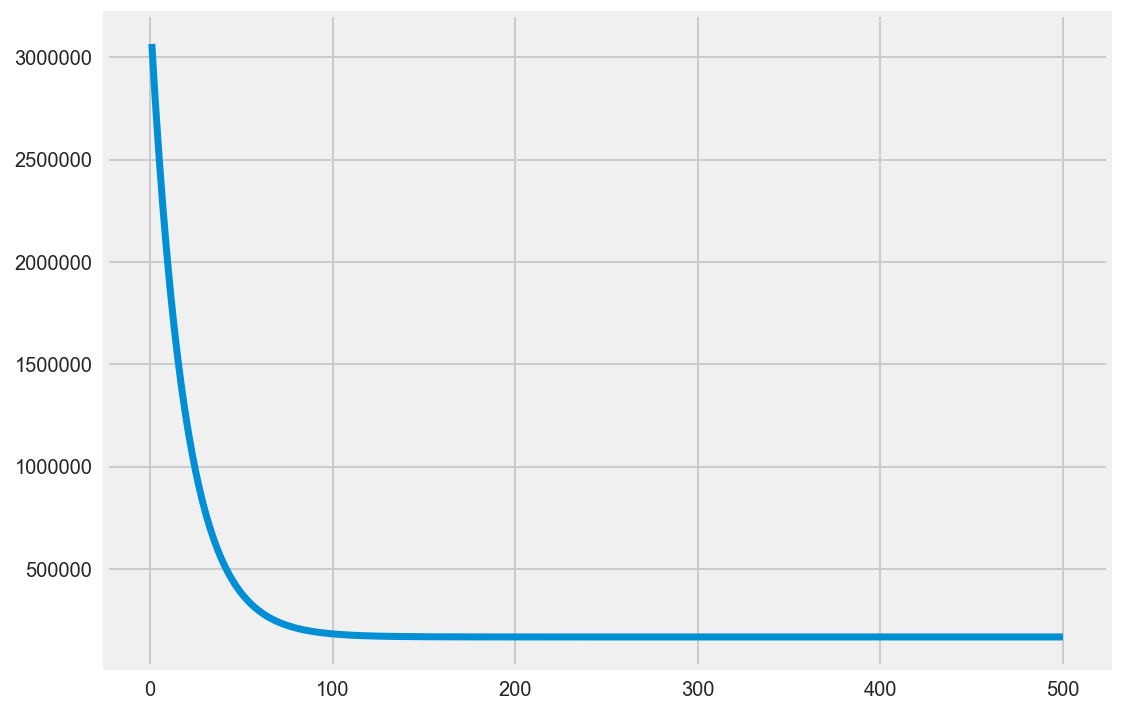

In [10]:
# MSE trajectory to iterations
fig, ax = plt.subplots(figsize=(8,6))
x_iters = range(1, 501)
ax.plot(x_iters, mse, lw=3.5)
plt.show()

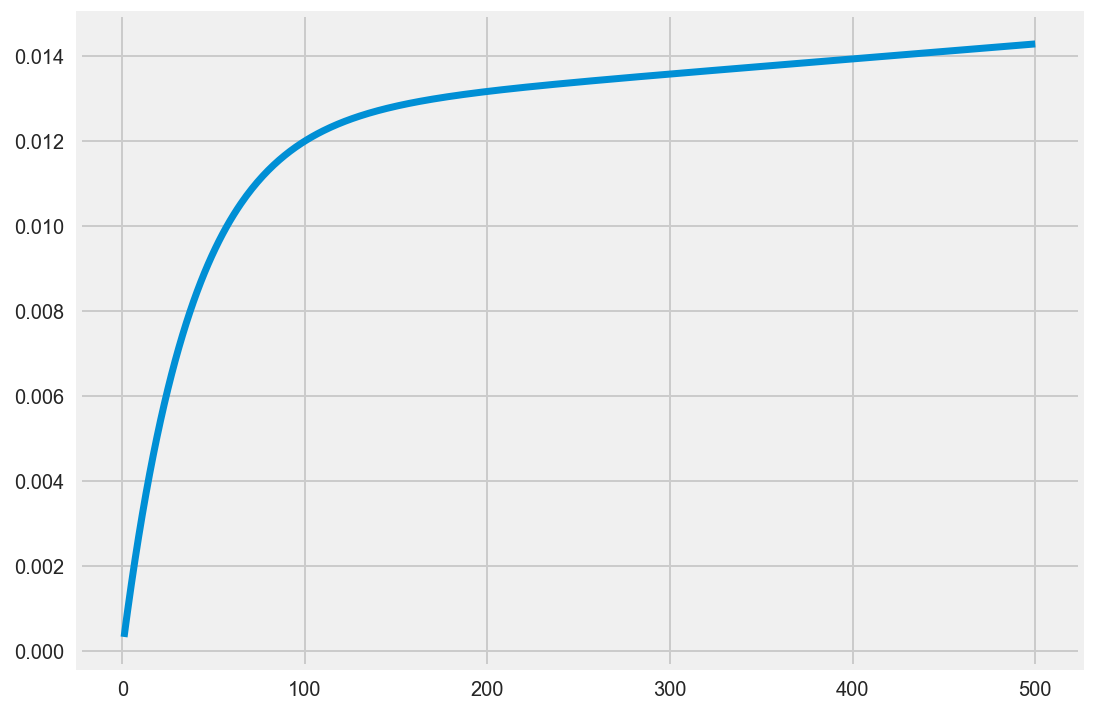

In [11]:
# Beta0 trajectory to iterations
fig, ax = plt.subplots(figsize=(8,6))
x_iters = range(1, 501)
ax.plot(x_iters, beta0s, lw=3.5)
plt.show()

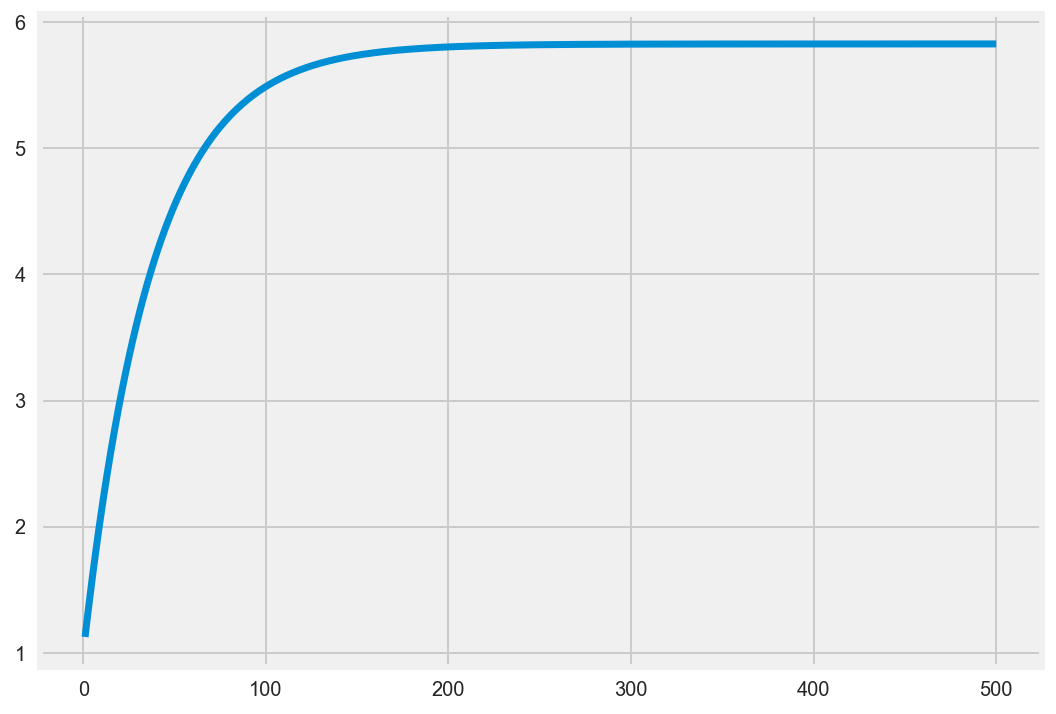

In [12]:
# Beta1 trajectory to iterations
fig, ax = plt.subplots(figsize=(8,6))
x_iters = range(1, 501)
ax.plot(x_iters, beta1s, lw=3.5)
plt.show()

<a id='linalg'></a>

## Linear algebra MLR generalization of the gradient descent code

---

Now that we have coded the gradient descent for a simple linear regression, we can generalize this code to work for a matrix of predictors instead of just one predictor. 

### New mean squared error loss function

This function calculates the mean of the squared errors using a [dot product](http://mathworld.wolfram.com/DotProduct.html) between the `X` predictor matrix and the `beta_array`:

In [13]:
def mean_squared_error(X, y, beta_array):
    y_hat = np.dot(X, beta_array)
    mean_sq_err = np.mean((y_true - y_hat)**2)
    return mean_sq_err

### New $\beta$ update function

This will update the value of $\beta$ array. We still use the partial derivitave formulas above, with some linear algebra tweaks to make it work with an arbitary $X$ predictor matrix.

In [14]:
def beta_update_function(X, y, beta_array, step_size):
    # create a transposed version of the X predictor array:
    Xt = X.T
    
    # predictions are the dot product of the X matrix and the beta matrix:
    y_hat = np.dot(X, beta_array)
    
    # residuals are the true y minus the predicted y
    residuals = y_hat - y
    
    # calculate the gradient from the partial derivatives.
    # this works out to actually do both at the same time.
    # How? Well, because the beta0 column is all 1s, the 
    # dot product turns out to be the same as the beta0
    # partial derivative function!
    gradient = np.dot(Xt, residuals) / (X.shape[0]/2.)
    
    # update the betas with the gradient:
    beta_array = beta_array - (step_size * gradient)
    
    return beta_matrix

### New gradient descent iteration update function

This is the function that wraps the gradient update with some number of iterations. It is the same, but takes an array of beta coefficients.

In [15]:
def run_gradient_descent(X, y, initial_beta_array, step_size, iterations=500):
    
    beta_array = initial_beta_array
    
    # Set up the MSE tracker
    mses = []
    mses.append(mean_squared_error(X, y, beta_array))
    
    # track the betas over the iterations:
    beta_arrays = []

    # update the betas via gradient descent:
    for i in range(iterations):
        beta_array = beta_update_function(X, y, beta_array, step_size)
        mses.append(mean_squared_error(X, y, beta_array))
        beta_arrays.append(beta_array)


<a id='interactive'></a>

## Interactive visualization of gradient descent

This interactive visualization lets you watch gradient descent solve the optimal coefficient values.

> **Note:** Because this is a very simple implementation, there is no automatic adjustment of step size, so setting this value can be finnicky and you sort of have to play around with it.

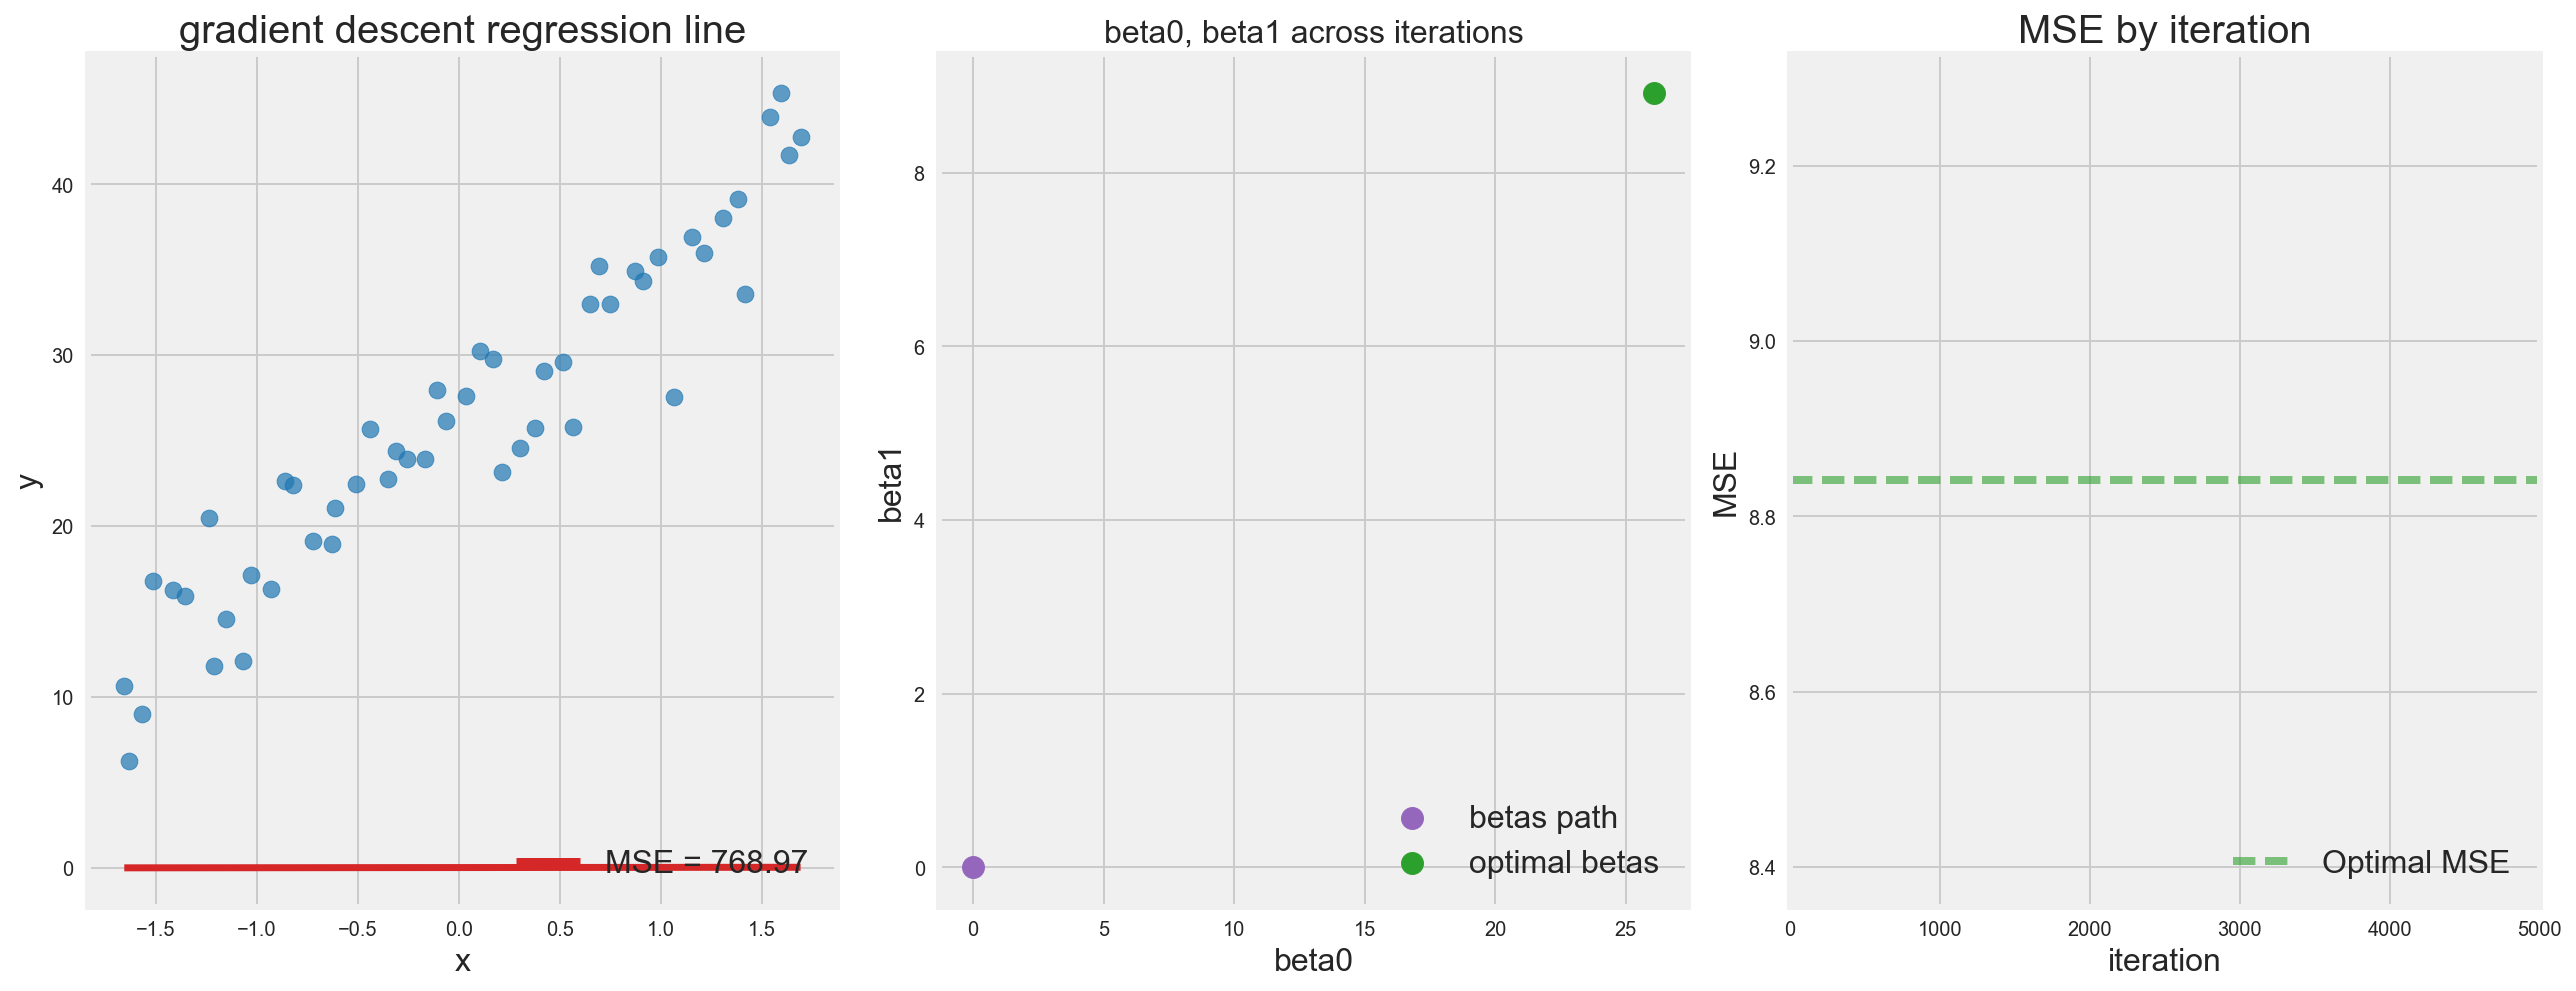

In [16]:
import imp
plotter = imp.load_source('plotter', '../code/gradient_descent.py')
from plotter import GradientDescentPlotter

gd_plotter = GradientDescentPlotter(step_size=0.001)
gd_plotter.run_gradient_descent(iterations=5000)
gd_plotter.gradient_interact()

<a id='fail'></a>

## Gradient descent can fail: a toy example

---

One of the most delicate things about gradient descent is the step size (also known as learning rate). If this is not tuned properly, the algorithm may never converge and in fact explode into extreme values.

But that is not the only pitfall with gradient descent: it can also get stuck in "local minima" and only works where there is a gradient to follow. 

Here is a toy example of a function where gradient descent will fail:

$$f(x, y) = \begin{cases}
2 x^2 & \quad \text{if $x \leq 1$}\\
2  & \quad \text{else}
\end{cases}$$

In [17]:
def func(x):
    if x <= 1:
        return 2 * x * x
    return 2

def gradient(x):
    if x <= 1:
        return 4 * x
    return 0

def gradient_descent(x, l=0.1):
    vector = np.array(x)
    return vector - l * np.array(gradient(x))


def iterate(x0, n=10):
    xs = [x0]
    ys = [func(x0)]
    for i in range(n):
        x = gradient_descent(xs[-1], l=0.1)
        xs.append(x)
        ys.append(func(x))
    return xs, ys

**Run the gradient descent algorithm starting at `x = -1.5` first, then try it at `x = 2`:**

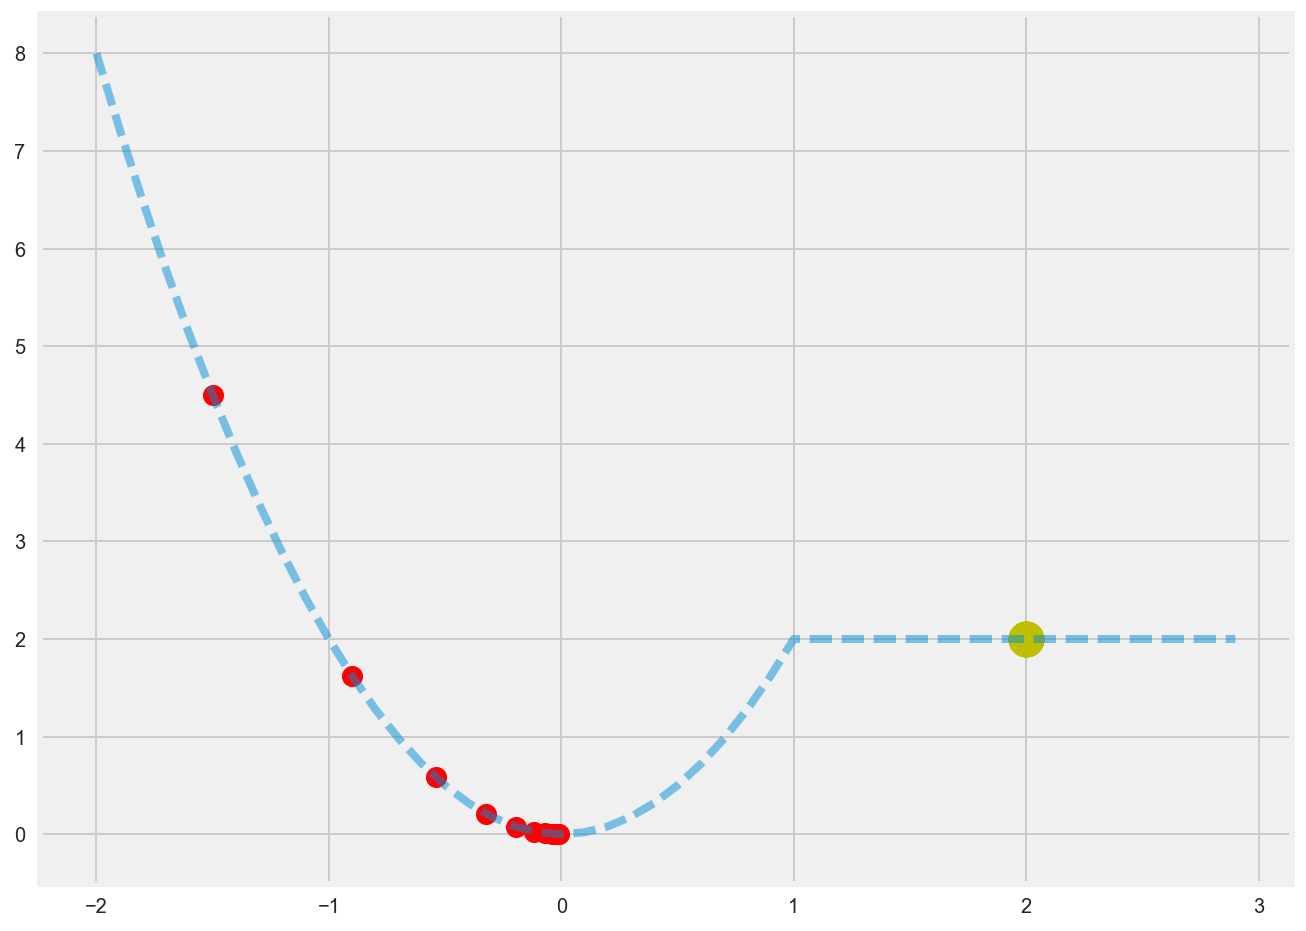

In [18]:
xs = np.arange(-2, 3, 0.1)
ys = map(func, xs)

plt.figure(figsize=(10,8))
plt.plot(xs, ys, alpha=0.5, ls='dashed')

# Start gradient descent at x = -1.5
xs2, ys2 = iterate(-1.5, n=10)
plt.scatter(xs2, ys2, c='r', s=100)

# Start gradient descent at x = 2
xs2, ys2 = iterate(2, n=10)
plt.scatter(xs2, ys2, c='y', s=300)

<a id='stochastic'></a>
## Stochastic Gradient Descent

---

What is the difference between gradient descent and *stochastic* gradient descent? It's actually a very small difference, but has big implications.

Instead of **all** the samples updating the gradient at a time, **only one** sample updates the gradient (iterating over all the observations, though this can change based on specification) within each overall iteration.

**Stochastic gradient descent has some nice properties over gradient descent:**
- It solves faster since it immediately starts to update the gradient.
- It can handle much, much larger datasets since it only needs to calculate a single row or small batch of rows of the entire dataset.

When using sklearn, there are only implementations of stochastic gradient descent solvers: `SGDRegressor` and `SGDClassifier`.